# EXAM

**Objective:** classify the tweets about Corona Virus as positive or negative; in the dataset there are 5 classes: `'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'`, you will have to eliminate neutral and convert the rest into positive and negative.

1. Exploratory Data Analsis (EDA): look closely at you data, the text, the target, any null values, any imbalance, non-numerical data to be converted (in data and target)?, etc.
2. Split the train set into Training,  Validation, & validation sets (0.75, 0.21), the test set is a separate file here.
3. Clean Textual Data
4. Vectorize Texts (one hot encoder, tfidf, embeddings (word2vec with gensim, ELMO, BERT, GPT, etc.))
5. ML Classification model(s) or DL model or an ensemble of several ML/DL or both ML and DL models
6. Choose and justify the choice of the evaluation metric
7. Hyperparameter optimization (Cross validation - hyperopt - Gridsearch)
8. Evaluate on Test set
9. Use Lime to explain one text classification
10. Use Shapley to explain globally the text classification

**Comment all your steps: justify your choices, analyze the results (whether positive or negative), and finally conclude by suggesting improvements and making recommendations.**

You can use one notebook for all your work or seperate the EDA from the training and finally the testing and interpretability. <br>
You can also use .py scripts (classes/functions) and initialize/call them from the notebook. <br>

The goal is to check that you understood how does an NLP data science project starts. <br>
you will be evaluated on the methods used and **the comments and analysis** you will provide. <br>
Bad test performance will not influence your grade as long as you propose improvements and elaborate on the reasons you think might have influenced this bad results. <br>

**NB:**
- Imbalance can be fixed by Over/Under sampling and Data Augmentation.<br> Using Textual Data Augmentation techniques (libraries like textattack.augmentation, NLPAug, backtranslations, etc.,) would be a bonus if used.
- Another bonus is granted if you keep the problem a multi-class classification instead of a binary one; the classes woul be:`'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'`

I have already started the EDA section for you.


## Imports


In [48]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from joblib import delayed, Parallel
from tqdm import tqdm

tqdm.pandas()
import warnings

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [49]:
import re
import spacy

spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Dataset

### Load train and test datasets

In [50]:
train_df = pd.read_csv('data/Corona_NLP_train.csv', encoding='latin').head(800)
test_df = pd.read_csv('data/Corona_NLP_test.csv', encoding='latin').head(200)

# change column names to lowercase 
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
print(f"> Train shape: {train_df.shape}")
print(f"> Test shape: {test_df.shape}")
print(f"> Columns: {train_df.columns}")
train_df

> Train shape: (800, 6)
> Test shape: (200, 6)
> Columns: Index(['username', 'screenname', 'location', 'tweetat', 'originaltweet',
       'sentiment'],
      dtype='object')


,username,screenname,location,tweetat,originaltweet,sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
795,4594,49546,#LeafNation #MagicFairyStyle,17-03-2020,Times of crisis are an opportunity to come tog...,Extremely Negative
796,4595,49547,She/ her,17-03-2020,Before watching #Supernatural : COVID-19 is sh...,Negative
797,4596,49548,NaN,17-03-2020,"There is plenty of food, toilet paper and hous...",Extremely Negative
798,4597,49549,"Los Angeles, CA",17-03-2020,Picture #01 \r\r\nYesterday last night me and ...,Negative


### Overview 

In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       800 non-null    int64 
 1   screenname     800 non-null    int64 
 2   location       639 non-null    object
 3   tweetat        800 non-null    object
 4   originaltweet  800 non-null    object
 5   sentiment      800 non-null    object
dtypes: int64(2), object(4)
memory usage: 37.6+ KB


In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       200 non-null    int64 
 1   screenname     200 non-null    int64 
 2   location       164 non-null    object
 3   tweetat        200 non-null    object
 4   originaltweet  200 non-null    object
 5   sentiment      200 non-null    object
dtypes: int64(2), object(4)
memory usage: 9.5+ KB


## EDA

In statistics, exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. 

### Missing Values

Now let us check for missing values in the dataset.

In [53]:
train_df.isnull().sum()

username           0
screenname         0
location         161
tweetat            0
originaltweet      0
sentiment          0
dtype: int64

In [54]:
columns_without_target_col = train_df.columns.drop('sentiment')
# column without missing values
train_df[columns_without_target_col].isnull().sum() / len(train_df) * 100

username          0.000
screenname        0.000
location         20.125
tweetat           0.000
originaltweet     0.000
dtype: float64

In [55]:
test_df[columns_without_target_col].isnull().sum() / len(test_df) * 100

username          0.0
screenname        0.0
location         18.0
tweetat           0.0
originaltweet     0.0
dtype: float64

### Duplicate Values

In [56]:
train_df.duplicated().sum()

0

In [57]:
test_df.duplicated().sum()

0

In [58]:
train_df["originaltweet"].duplicated().sum()

0

In [59]:
test_df["originaltweet"].duplicated().sum()

0

### Target Distribution

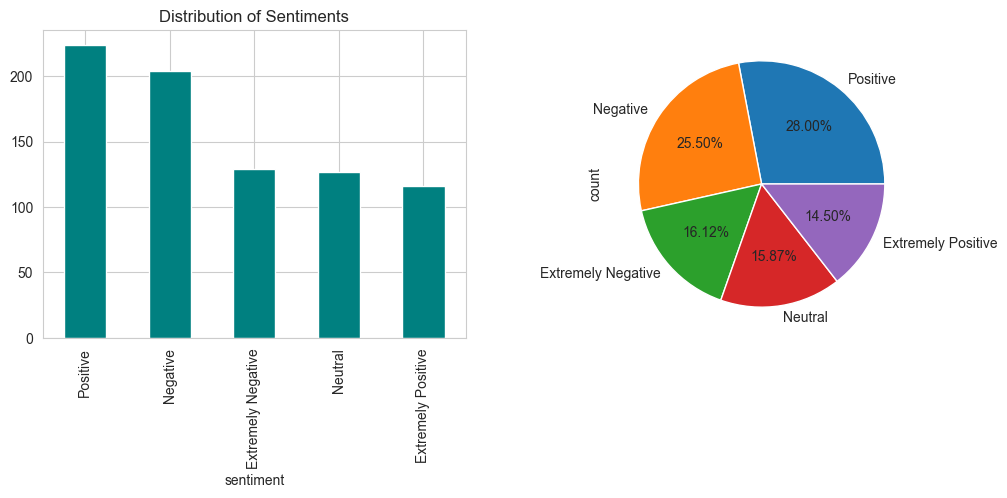

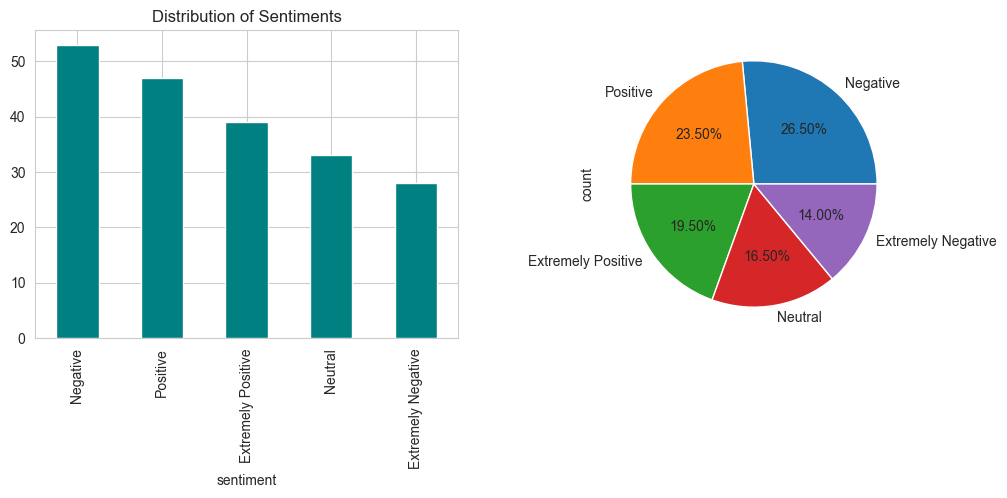

In [60]:
for df in [train_df, test_df]:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)
    
    df.sentiment.value_counts().plot.bar(ax=axes[0], color='teal')
    axes[0].set_title('Distribution of Sentiments')
    
    df.sentiment.value_counts().plot.pie(ax=axes[1], autopct='%1.2f%%')
    plt.show()

## Clean Textual Data

In [61]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase the words
    text = text.lower()
    # Lemmatize each word
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.lemma_ and not token.is_stop and not token.is_punct])
    return text


# Clean the tweets
train_df['originaltweet_clean'] = train_df['originaltweet'].progress_apply(lambda x: clean_text(x))
# Save 
train_df.to_csv('data/train_clean.csv', index=False)
train_df

100%|██████████| 800/800 [00:10<00:00, 79.09it/s]


,username,screenname,location,tweetat,originaltweet,sentiment,originaltweet_clean
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth elderly disabl...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock \r\r\n\r\r\n not panic food need \r...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket covid19 outbreak \r\r\n\r\r\...
...,...,...,...,...,...,...,...
795,4594,49546,#LeafNation #MagicFairyStyle,17-03-2020,Times of crisis are an opportunity to come tog...,Extremely Negative,time crisis opportunity come humanity amp help...
796,4595,49547,She/ her,17-03-2020,Before watching #Supernatural : COVID-19 is sh...,Negative,watch supernatural covid19 shut mass panic f...
797,4596,49548,NaN,17-03-2020,"There is plenty of food, toilet paper and hous...",Extremely Negative,plenty food toilet paper household essential e...
798,4597,49549,"Los Angeles, CA",17-03-2020,Picture #01 \r\r\nYesterday last night me and ...,Negative,picture 01 \r\r\n yesterday night dad go groce...


In [62]:
test_df['originaltweet_clean'] = test_df['originaltweet'].progress_apply(lambda x: clean_text(x))
test_df.to_csv('data/test_clean.csv', index=False)
test_df

100%|██████████| 200/200 [00:02<00:00, 76.18it/s]


,username,screenname,location,tweetat,originaltweet,sentiment,originaltweet_clean
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trend new yorker encounter supermarket shelf p...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,not find hand sanitizer fred meyer turn amazon...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,find protect love one coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hit newyork city anxious shopper ...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...
...,...,...,...,...,...,...,...
195,196,45148,deep south,11-03-2020,?People at #highrisk \r\r\nCDC finally says yo...,Positive,people highrisk \r\r\n cdc finally say prepare...
196,197,45149,"Roma, Lazio",11-03-2020,"If you still can, stock up on dry and canned f...",Neutral,stock dry canned food bottled water water puri...
197,198,45150,London,11-03-2020,Popped into my local supermarket after work. T...,Positive,pop local supermarket work basket noticeably c...
198,199,45151,USA,11-03-2020,IÂm trying not to be paranoid about the #coro...,Extremely Positive,iâm try paranoid coronavirus admit binge prepp...


## Vectorize Texts

We will use TF-IDF vectorizer to vectorize the texts. 

TF-IDF stands for Term Frequency - Inverse Document Frequency. It is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus.

In [63]:
train_df.head()
# classe to number
for df in [train_df, test_df]:
    df['sentiment'] = df['sentiment'].map({'Extremely Negative': 0, 'Extremely Positive': 1, 'Negative': 0, 'Neutral': 0, 'Positive': 1})
    
train_df.head()

,username,screenname,location,tweetat,originaltweet,sentiment,originaltweet_clean
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1,coronavirus australia woolworth elderly disabl...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1,food stock \r\r\n\r\r\n not panic food need \r...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0,ready supermarket covid19 outbreak \r\r\n\r\r\...


<Axes: ylabel='count'>

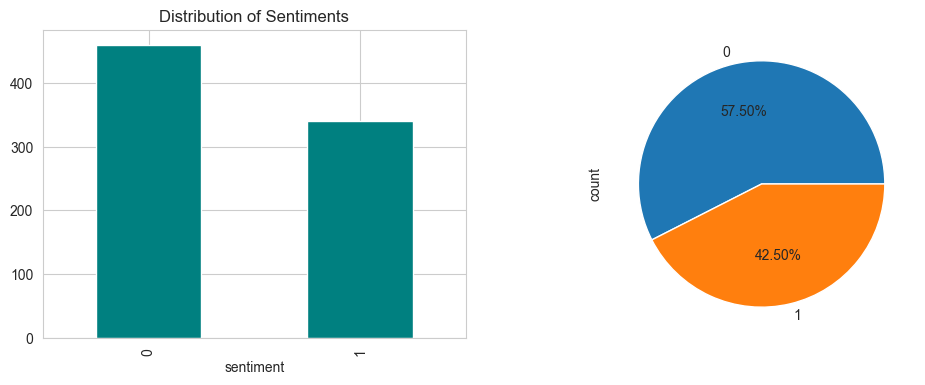

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)

train_df.sentiment.value_counts().plot.bar(ax=axes[0], color='teal')
axes[0].set_title('Distribution of Sentiments')

train_df.sentiment.value_counts().plot.pie(ax=axes[1], autopct='%1.2f%%')

### TF-IDF 

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

### The split

In [66]:
# Transform features
X_train = train_df.originaltweet_clean
X_tfidf_train = vectorizer.fit_transform(X_train)
X_test = test_df.originaltweet_clean
X_tfidf_test = vectorizer.transform(X_test)

# Get the target
y_train = train_df.sentiment
y_test = test_df.sentiment

In [67]:
print('> Before vectorization:', len(X_train[2]), "\n")
print('> After vectorization:', X_tfidf_train[2].shape)

> Before vectorization: 94 

> After vectorization: (1, 3567)


## Machine Learning Model

### Random Forest

#### Hyperparameter Tuning

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Create the basic parameter grid based on the results of random search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Create a based model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
best_rf = grid_search.fit(X_tfidf_train, y_train)
best_rf


Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

#### Train

In [86]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(**best_rf.best_params_)

# Fit the model to the training data
rf.fit(X_tfidf_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200)

#### Evaluate

Accuracy:  0.695 

Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.94      0.78       114
           1       0.82      0.37      0.51        86

    accuracy                           0.69       200
   macro avg       0.74      0.66      0.65       200
weighted avg       0.73      0.69      0.66       200
 

Confusion Matrix:


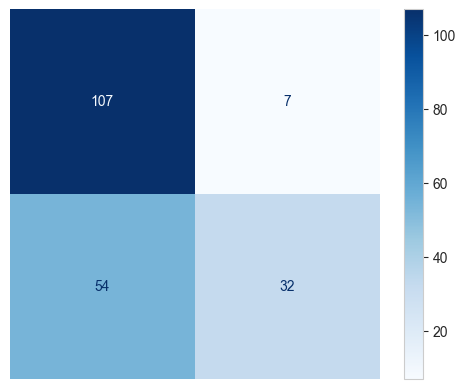

In [87]:
# Predict
y_pred = rf.predict(X_tfidf_test)
# Print the accuracy score
print('Accuracy: ', accuracy_score(y_test, y_pred), "\n")
# Print the classification report
print('Classification Report: \n', classification_report(y_test, y_pred), "\n")
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(cmap='Blues')
plt.axis('off')

plt.show()

### Logistic Regression

#### Train

In [70]:
from sklearn.linear_model import LogisticRegression
    
# Initialize the Logistic Regression Classifier
logreg = LogisticRegression(n_jobs=1, C=1e5)

# Fit the model to the training data
logreg.fit(X_tfidf_train, y_train)

LogisticRegression(C=100000.0, n_jobs=1)

#### Evaluate

Accuracy:  0.705 

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.78      0.75       114
           1       0.68      0.60      0.64        86

    accuracy                           0.70       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.70      0.70      0.70       200
 

Confusion Matrix:


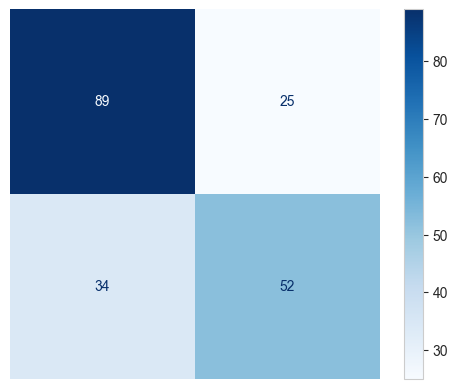

In [71]:
# Predict
y_pred = logreg.predict(X_tfidf_test)
# Print the accuracy score
print('Accuracy: ', accuracy_score(y_test, y_pred), "\n")
# Print the classification report
print('Classification Report: \n', classification_report(y_test, y_pred), "\n")
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
ConfusionMatrixDisplay(cm, display_labels=logreg.classes_).plot(cmap='Blues')
plt.axis('off')

plt.show()


## XGBoost

In [ ]:
#### Train

In [78]:
from xgboost import XGBClassifier

# Initialize the XGBClassifier
xgb = XGBClassifier(n_estimators=100, n_jobs=-1)

# Fit the model to the training data
xgb.fit(X_tfidf_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#### Evaluate

Accuracy:  0.655 

Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.81      0.73       114
           1       0.64      0.45      0.53        86

    accuracy                           0.66       200
   macro avg       0.65      0.63      0.63       200
weighted avg       0.65      0.66      0.64       200
 

Confusion Matrix:


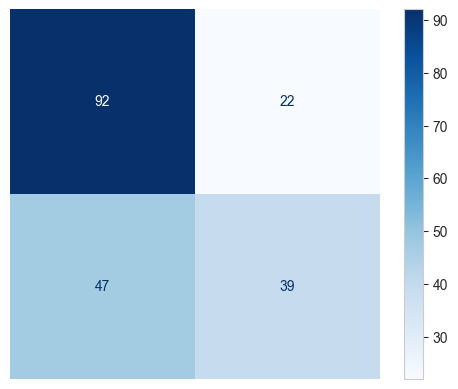

In [79]:
# Predict
y_pred = xgb.predict(X_tfidf_test)
# Print the accuracy score
print('Accuracy: ', accuracy_score(y_test, y_pred), "\n")
# Print the classification report
print('Classification Report: \n', classification_report(y_test, y_pred), "\n")
# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
ConfusionMatrixDisplay(cm, display_labels=xgb.classes_).plot(cmap='Blues')
plt.axis('off')

plt.show()